## CSCI E-116 Assignment #5
### TV Lift Analysis - Which model is the best?
### Roger Zeng
**10/10/2022**

In [198]:
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
import statsmodels.graphics.tsaplots as tp

# for modeling
from statsmodels.formula.api import ols
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX

# model eval
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

In [106]:
# Data files to import and associated column data types
infile = 'TVlift.xlsx'

# import data from file named above
full = pd.read_excel(infile, header=0, index_col=None, parse_dates=True)

,date,sb,snb,tv,sales
0,2016-04-01,0.0,26659.80,0.0,1140.0
1,2016-04-02,0.0,24792.20,0.0,1082.5
2,2016-04-03,0.0,23345.23,0.0,1187.5
3,2016-04-04,0.0,18294.98,0.0,1082.5
4,2016-04-05,0.0,13665.93,0.0,655.0


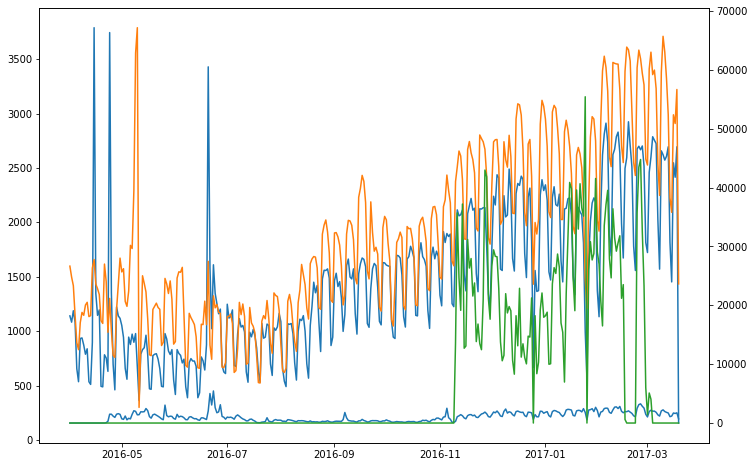

In [135]:
# Plot data as is
fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.plot(full['date'], full[['sales']])
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(full['date'], full[['sb','snb','tv']])
plt.show()

In [108]:
# add lag and day of week
full['lag1'] = full['sales'].shift(1)
full['dow'] = full['date'].apply(lambda x: x.isoweekday())
full = pd.concat([full, pd.get_dummies(full['dow'], prefix='dow', drop_first=True)], axis=1)

In [218]:
# split training and test data set
train = full.iloc[0:333,]
test = full.iloc[333:,]

In [214]:
# ADF test to verify stationarity
full['sales_d1'] = (full['sales']-full['sales'].shift(1))  # d=1
adf_test = adfuller(full['sales_d1'].iloc[1:], autolag = 'AIC')
print( f"Augmented Dickey Fuller Test \n \
ADF Statistic = {adf_test[0]:.3f} \np-value = {adf_test[1]:.4f}\n# of lags = {adf_test[2]}")

Augmented Dickey Fuller Test 
 ADF Statistic = -5.376 
p-value = 0.0000
# of lags = 14


### First order difference, ADF test was statistically significant

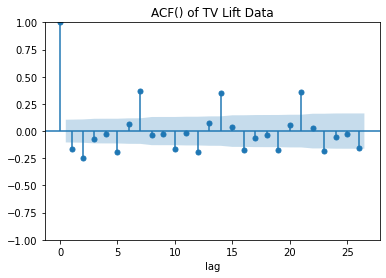

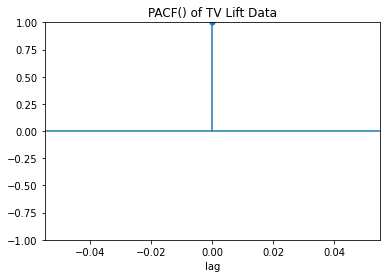

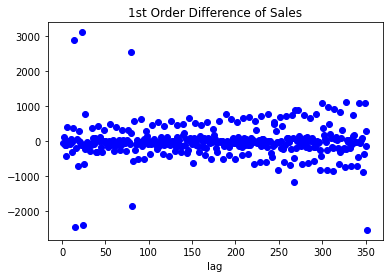

In [241]:
# acf and pacf plots
fig, ax0 = plt.subplots()
tp.plot_acf(sales_diff, ax=ax0)
plt.gca().set(title='ACF() of TV Lift Data', xlabel='lag')

fig, ax1 = plt.subplots()
tp.plot_pacf(full['sales_d1'], method='ywm', ax=ax1)
plt.gca().set(title='PACF() of TV Lift Data', xlabel='lag')

fig, ax2 = plt.subplots()
ax2.plot(sales_diff, 'bo')
plt.gca().set(title='1st Order Difference of Sales', xlabel='lag')

plt.show()

### ACF plot appears to be stationary with a weekly seasonality 
### PACF plot indicates a MA(2) order
### First order difference of data look stationary

In [243]:
# build models
fit = []
fit.append(ols("sales ~ sb + snb + tv", data=train).fit())
fit.append(ols("sales ~ sb + snb + tv + dow_2 + dow_3 + dow_4 + dow_5 + dow_6 + dow_7", data=train).fit())
fit.append(ols("sales ~ lag1 + sb + snb + tv", data=train).fit())
fit.append(ols("sales ~ lag1 + sb + snb + tv + dow_2 + dow_3 + dow_4 + dow_5 + dow_6 + dow_7", data=train).fit())

# SARIMAX model (ARIMA with seasonality and exogenous regressors (tv, sb, snb))
# p=0, d=0 (already working with 1st order difference), q = 2 and seasonal d=7 (weekly)
fit.append(SARIMAX(train['sales_d1'], exog = train[['tv', 'sb', 'snb']], 
                   order=(0, 0, 2), seasonal_order=(0,0,0,7)).fit())

# Prophet
pdata = train[['date','sales']].rename(columns={'date':'ds','sales':'y'})
fit.append(Prophet(weekly_seasonality=True).fit(pdata))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [245]:
# Predict values
pred = []

# Model 0 exog only
pred.append(fit[0].predict(test[['tv','sb','snb']]))
# Model 1 dow dummies
pred.append(fit[1].predict(test[['tv','sb','snb', 'dow_2','dow_3', 'dow_4', 'dow_5', 'dow_6', 'dow_7']]))
# Model 2 lag1
pred.append(fit[2].predict(test[['lag1','tv','sb','snb']]))
# Model 3 lag1 and dow dummies
pred.append(fit[3].predict(test[['lag1','tv','sb','snb', 'dow_2','dow_3', 'dow_4', 'dow_5', 'dow_6', 'dow_7']]))
# Model 4 SARIMAx
pred_4 = fit[4].forecast(steps=len(test), exog=test[['tv','sb','snb']])
pred.append(pred_4+test['sales'])

# Model 5 Prophet
pred.append(fit[5].predict(fit[5].make_future_dataframe(periods=len(test)))[-20:]['yhat'])

In [246]:
# RMSE tests
RMSE = []
for i in range(len(fit)):
    RMSE.append(mean_squared_error(test['sales'], pred[i], squared=False))
    print(f"Model {i} RMSE = {RMSE[i]:.3f}")

print(f"The winner by RMSE is Model {np.argmin(RMSE)} with RMSE of {np.min(RMSE):.3f}")

Model 0 RMSE = 309.716
Model 1 RMSE = 343.924
Model 2 RMSE = 364.696
Model 3 RMSE = 408.133
Model 4 RMSE = 28.303
Model 5 RMSE = 598.281
The winner by RMSE is Model 4 with RMSE of 28.303


### The SARIMAX model is by far the best performing model with:
- First order difference
- AR(0)
- MA(2)
- Weekly (7-day) seasonal order

### Indeed, the plot below shows that the SARIMAX model prediction (green line) almost predict exactly on each of the observation in the out-of-sample test set (x mark).

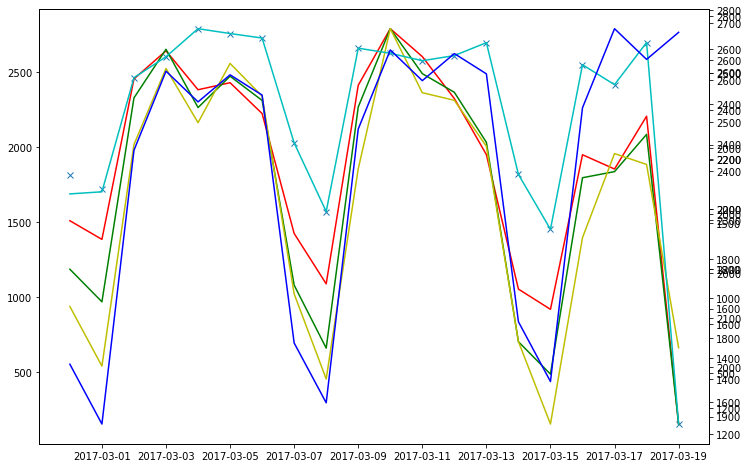

In [261]:
# Plot data as is
fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.plot(test['date'], test['sales'],'x')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(test['date'], pred[0], 'r')
ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax3.plot(test['date'], pred[1], 'g')
ax4 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax4.plot(test['date'], pred[3], 'y')
ax5 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax5.plot(test['date'], pred[4], 'c')
ax6 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax6.plot(test['date'], pred[5], 'b')

plt.show()